## Objet du programme :

Le but de ce programme est de réaliser un clustering de type de parcours à partir d'un log d'activité mentionnant :

Un identifiant

Une date associée à l'activité

Un type d'activité

## SECTION PARAMETRAGE

In [1]:
from datetime import datetime

#import pyodbc
import sqlalchemy
#import sqlalchemy as msql
#import Connexion_bdd as Cx_bdd
import numpy as np
import pandas as pd
import Requetes_SQL as Req_SQL
import matplotlib.pyplot as plt
import seaborn as sns
#import dtw as dtw
#import tsfresh #TimeSeries Transformation library
import my_custom_func_TS_Clust_1 as Mcftsc
import my_custom_func_Clustering as McfC
import my_custom_func_Carepath_plotting as Mcfcp
import my_custom_func_config as Mcfconf
import mlflow

from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics, tree

#SET THE RANDOM SET FOR SKLEARN
#np.random.seed(0)

In [2]:
#Project Classes
#import FSQL_Classes as FSQLC
import Sql_Alchemy_Classes as AlSQL
#import Parcours_Classes as PC

2023-12-20 09:45:48,875 INFO sqlalchemy.engine.Engine SELECT CAST(SERVERPROPERTY('ProductVersion') AS VARCHAR)
2023-12-20 09:45:48,876 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-12-20 09:45:48,877 INFO sqlalchemy.engine.Engine SELECT schema_name()
2023-12-20 09:45:48,878 INFO sqlalchemy.engine.Engine [generated in 0.00048s] ()
2023-12-20 09:45:48,879 INFO sqlalchemy.engine.Engine SELECT CAST('test max support' AS NVARCHAR(max))
2023-12-20 09:45:48,880 INFO sqlalchemy.engine.Engine [generated in 0.00040s] ()
2023-12-20 09:45:48,881 INFO sqlalchemy.engine.Engine SELECT TOP (10) [idUFX_Ress_Equ] FROM [ICO_Activite].[dbo].[Listing_UF_V3]
2023-12-20 09:45:48,881 INFO sqlalchemy.engine.Engine [raw sql] ()
Connexion BDD - OK


In [3]:
#Open config.csv file as a dict

# Construct the file path in the parent directory
file_path = "../07-Batch_configuration/export_config.csv"

#file_path = 'config_py.csv'  # Replace 'your_file.csv' with your CSV file path
config = pd.read_csv(file_path, encoding='ISO-8859-1')

row_index = 0
Ac_config = config.iloc[row_index]

In [4]:
Ac_config

ID_RUN                                                                 1
Experiment                                    Exp_Clustering parcours_V1
Experiment_tag_1                                             exp.version
Experiment_tag_2                                                     0.1
DS_Prefix                                                        000_DS_
                                             ...                        
CPP_Order                                                       Max_J_V1
CPP_Save_Tble_Name                                      Exp_NIP_Cluster1
CPP_Requete            SELECT Table_Acte.[NIP]\n\t  ,Table_Cluster.CL...
CPP_Filter_df_col                                                  Phase
CPP_Filter_df_value                                           Traitement
Name: 0, Length: 62, dtype: object

In [5]:
Experiment_name=Ac_config['Experiment']
Experiment_tag1=Ac_config['Experiment_tag_1']
Experiment_tag2=Ac_config['Experiment_tag_2']
Mcfconf.my_custom_func_MLFLOWconfig(Experiment_name,Experiment_tag1,Experiment_tag2)

Experiment_id: 255985384762415284
Artifact Location: mlflow-artifacts:/255985384762415284
Tags: {'exp.version': '0.1'}
Lifecycle_stage: active


## IMPORT DES DONNEES

In [6]:
DSprefix='000_DS_'
Create_dataset_parameters={DSprefix + 'My_NIP_filter_1rst_date': '01-01-2019 00:00:00',
                            DSprefix + 'My_NIP_filter_2nd_date_delta_in_days': 2,
                            DSprefix + 'Site': '2',
                            DSprefix + 'Start_Window_time': '01-09-2018 00:00:00',
                            DSprefix + 'End_Window_time': '12-31-2020 00:00:00',
                            }
myouputpath='../06 - Temp_outputs/'

In [7]:
Create_dataset_parameters

{'000_DS_My_NIP_filter_1rst_date': '01-01-2019 00:00:00',
 '000_DS_My_NIP_filter_2nd_date_delta_in_days': 2,
 '000_DS_Site': '2',
 '000_DS_Start_Window_time': '01-09-2018 00:00:00',
 '000_DS_End_Window_time': '12-31-2020 00:00:00'}

In [8]:
DSprefix=Ac_config['DS_Prefix']
Create_dataset_parameters={DSprefix + 'My_NIP_filter_1rst_date': Ac_config['My_NIP_filter_1rst_date'],
                            DSprefix + 'My_NIP_filter_2nd_date_delta_in_days': int(Ac_config['My_NIP_filter_2nd_date_delta_in_days']),
                            DSprefix + 'Site': str(Ac_config['Site']),
                            DSprefix + 'Start_Window_time': Ac_config['Start_Window_time'],
                            DSprefix + 'End_Window_time': Ac_config['End_Window_time'],
                            }
myouputpath=Ac_config['myouputpath']

In [9]:
Create_dataset_parameters

{'000_DS_My_NIP_filter_1rst_date': '01-01-2019 00:00:00',
 '000_DS_My_NIP_filter_2nd_date_delta_in_days': 1,
 '000_DS_Site': '2',
 '000_DS_Start_Window_time': '01-09-2018 00:00:00',
 '000_DS_End_Window_time': '12-31-2020 00:00:00'}

In [10]:
mlflow.log_params(Create_dataset_parameters)

In [11]:
Caracteristiques_Dataset=Mcftsc.Create_dataset(Create_dataset_parameters,DSprefix)

STEP 1.0 : Delete old Tables
2023-12-20 09:45:52,260 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-20 09:45:52,261 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Py_A_Actes_Export
2023-12-20 09:45:52,261 INFO sqlalchemy.engine.Engine [generated in 0.00053s] ()
2023-12-20 09:45:52,265 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.1 : Filter NIP ON /n Site = 2/n Date1  = 2019-01-01 00:00:00 - Date2  = 2019-01-02 00:00:00 - launched at 2023-12-20 09:45:52.266790
2023-12-20 09:45:52,268 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-20 09:45:52,268 INFO sqlalchemy.engine.Engine  EXECUTE Preproc_A0_Filter_NIP_BY_2_DATES_AND_SITE_AND_DATASET_ON_2_DATES A_Actes_ICO_2018_2021_V2_TRIMED,Tmp_Py_A_Actes_Export,'2019-01-01 00:00:00','2019-01-02 00:00:00','2018-01-09 00:00:00','2020-12-31 00:00:00',2
2023-12-20 09:45:52,269 INFO sqlalchemy.engine.Engine [generated in 0.00058s] ()
2023-12-20 09:45:53,069 INFO sqlalchemy.engine.Engine COMMIT
STEP 1.2 : Prepare_Dat

In [12]:
# Create the DataFrame
df = pd.DataFrame.from_dict(Caracteristiques_Dataset)

# Convert specified columns to dictionary
mydict = df.iloc[:, 6:].to_dict(orient='list')

# Filter dictionary to contain only float values and not lists
for key, value in mydict.items():
    if len(value) == 1 :
        mydict[key] = value[0]

mlflow.log_metrics(mydict)

## AFFICHAGE GENERAL DES DONNEES

In [13]:
#Get all actes in the Dataset

Requete = """
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  """
  
Actes_Total=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,True) #FSQLC.F_SQL_Requete(FSQLC.cnxn,Requete,FSQLC.pyodbc,'No')
Actes_Total


2023-12-20 09:46:18,972 INFO sqlalchemy.engine.Engine 
  SELECT *
  FROM [ICO_Activite].[dbo].[Tmp_A_Actes_Table_Analyse]
  
2023-12-20 09:46:18,972 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


ID_A         NIP       N_S       DD_A       DF_A       DD_M  \
0         619588  N201802529  N1854568 2019-04-15 2019-04-15 1899-12-30   
1         619616  N201802083  N1786027 2019-03-08 2019-03-08 1899-12-30   
2         619689  N201802083  N1886171 2019-08-14 2019-08-14 1899-12-30   
3         619697  N201802258  N1844732 2019-06-21 2019-06-21 1899-12-30   
4         619741  N201805962  N1900273 2019-09-12 2019-09-12 1899-12-30   
...          ...         ...       ...        ...        ...        ...   
105799  15060648  N201305765  N2101909 2020-10-18 2020-10-18 1899-12-30   
105800  15060649  N201305765  N2101909 2020-10-09 2020-10-09 1899-12-30   
105801  15060650  N201305765  N2101909 2020-10-09 2020-10-09 1899-12-30   
105802  15060651  N201305765  N2101909 2020-10-11 2020-10-11 1899-12-30   
105803  15060652  N201305765  N2101909 2020-10-11 2020-10-11 1899-12-30   

             HD_M       DF_M       HF_M   UFX  ... AC_Asso Lc_Prix UFH UFH_L  \
0      1899-12-30 1899-12-30 1899-12-30  9014  ...       1                     
1      1899-12-30 1899-12-30 1899-12-30  7172  ...       0                     
2      1899-12-30 1899-12-30 1899-12-30  9064  ...       1                     
3      1899-12-30 1899-12-30 1899-12-30  9062  ...       0                     
4      1899-12-30 1899-12-30 1899-12-30  8532  ...       0                     
...           ...        ...        ...   ...  ...     ...     ...  ..   ...   
105799 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
105800 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
105801 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
105802 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             
105803 1899-12-30 1899-12-30 1899-12-30  9018  ...       0    0.27             

       Prix_Acte Cout_Acte Statut Code_Equip Site Source  
0           37.8      37.8      E               2   CCAM  
1          14.26     14.26      E               2   CCAM  
2          66.42     66.42      E               2   CCAM  
3          21.28     21.28      H               2   CCAM  
4          89.54         0      E               2   CCAM  
...          ...       ...    ...        ...  ...    ...  
105799                          H               2   NGAP  
105800                          H               2   NGAP  
105801                          H               2   NGAP  
105802                          H               2   NGAP  
105803                          H               2   NGAP  

[105804 rows x 32 columns]

AFFICHAGE DES PARCOURS COMPLETS DES PATIENTS SELECTIONNES

In [14]:
#import importlib
#importlib.reload(Mcftsc)

2023-12-20 09:46:20,542 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP

2023-12-20 09:46:20,543 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


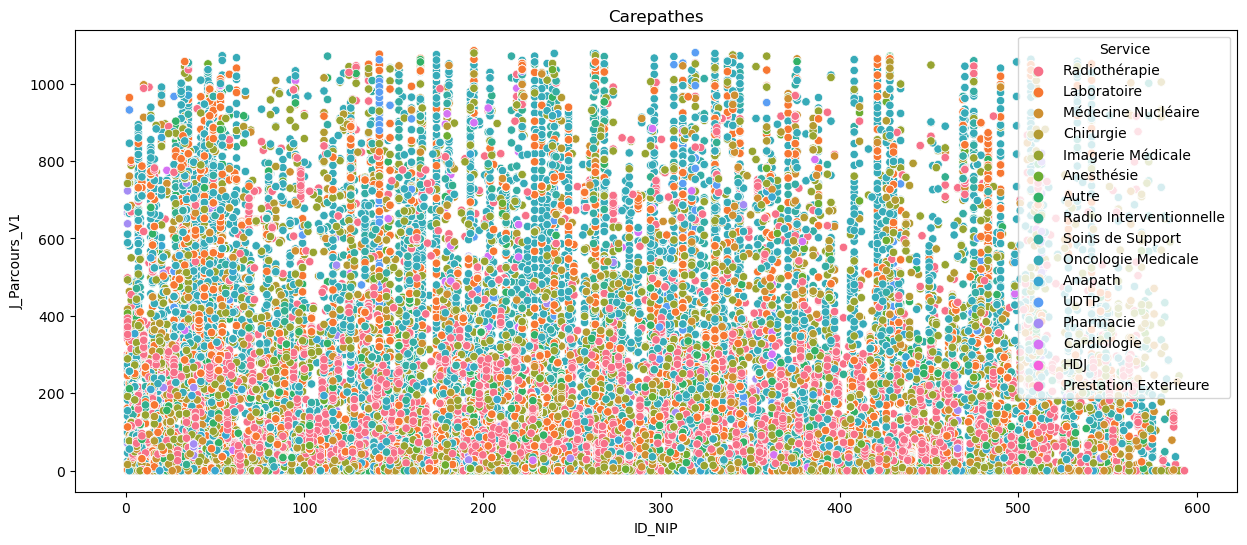

In [15]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  --WHERE Table_Cluster.NIP = Table_Acte.NIP
"""
df_Actes_graph=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

Mcftsc.plot_carepath(df_Actes_graph,myouputpath+ 'Actes_total.png',mlflow,"DS_General_plot")
#mlflow.log_artifact(myouputpath+'Actes_total.png', "DS_General_plot")

AFFICHAGE DES PARCOURS RADIOTHERAPIE DES PATIENTS

2023-12-20 09:46:27,094 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'

2023-12-20 09:46:27,095 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


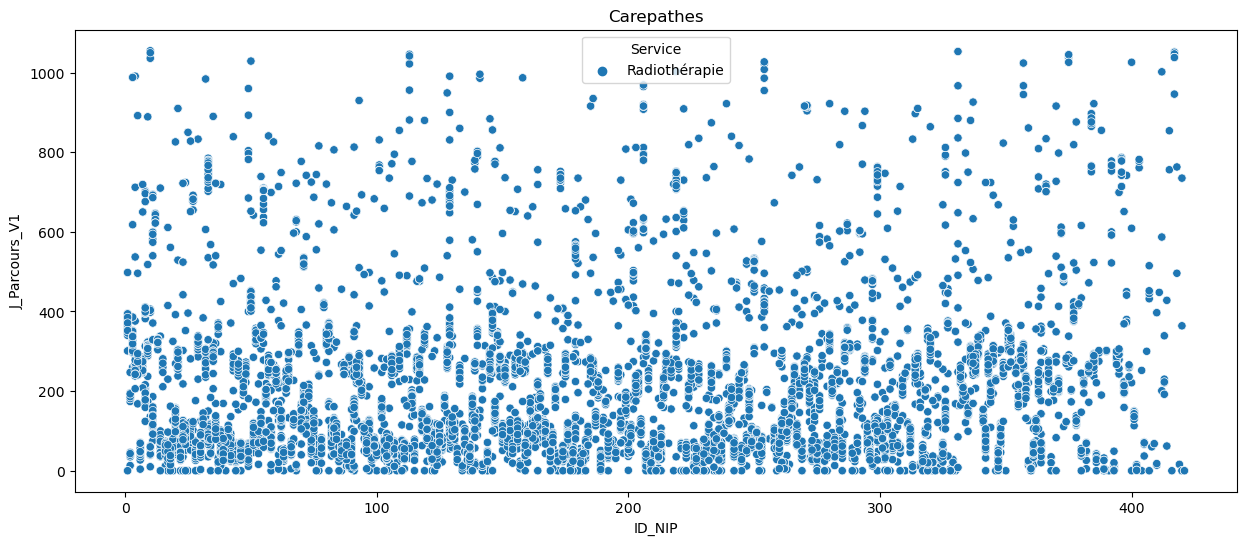

In [16]:
#Recuperer une table acte pour affichage
Requete="""SELECT Table_Acte.[NIP]
	  --,Table_Cluster.Cluster
	  --,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 --, [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Acte.[Service] = 'Radiothérapie'
"""
df_Actes_graph0=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

myoutputfile='Actes_rdth.png'
Mcftsc.plot_carepath(df_Actes_graph0,myouputpath + 'Actes_rdth.png',mlflow, "DS_General_RDTH_plot")
#mlflow.log_artifact(myouputpath + 'Actes_rdth.png', "DS_General_RDTH_plot")

## PARAMETRES D'AGGREGATION :

### creation d'un dictionnaire pour les multiples requetes d'aggrégation

Aggreg_parameters
    #PARAM1 = CHOICE = 
       	#-- 0 : REPORT DAYLY turnover from stardate of calendar (1 column = 1 DAY), CURSOR LINES ARE DAYS
		#-- 1 : REPORT WEEKLY turnover from stardate of calendar  (1 column = 1 WEEK), CURSOR LINES ARE WEEKS
		#-- 2 : REPORT MONTHLY turnover from stardate of calendar  (1 column = 1 month), CURSOR LINES ARE MONTHS
		#-- 3 : REPORT TRIMESTER turnover for the @YEAR (1 column = 3 months), CURSOR LINES ARE TRIMESTERS
		#-- 4 : REPORT ALL YEAR turnovers (1 column = 1 Year), CURSOR LINES ARE YEARS
    'Report_type': '2',  #--1

    #PARAM2 'TYPE AGGREG' --PARAMETER 3: @AggParameter as nvarchar(20)
		#--CALENDAR : Par date calendaire
		#--PARCOURS : Par date de parcours
    'Aggreg_type': 'PARCOURS',

    #Date ref
    'Date_ref' : "''",

    #0 --PARAMETER 4 : @AggParameter_min as int (NB jours)
    'Start_at_item': '0',

    #50 --PARAMETER 5 : @AggParameter_max as int (NB jours)
    'Stop_at_item': '36', # --104

    #'PRESENCE'	-- PARAMETER 4 : @AggMeth as nvarchar(20) --OK
		#--PRESENCE : -> FUNCTION COUNT
		#--COUNT -> FUNCTION SUM
		#--DENSITE -> Function SUM / Length of aggregation choice (1, 7, 30.41 , 365.25)
    'Method': 'COUNT',

    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20
          #--0-ALL
          #--1-SERVICE -> from Listing_UF_V3
          #--2-ACTIVITE -> from Listing_UF_V3
          #--3-PHASE PARCOURS -> from Listing_UF_V3
          #--4-DIMENSION PARCOURS -> from Listing_UF_V3
          #--5-POIDS ACTE -> from Listing_UF_V3
          #--6-TYPE DE SEQUENCE -> from Tmp_Type_Seq
          #--7-TYPE DE PARCOURS-- -> (After Clustering only)
          #--8-R_NGAP
          #--9-R_CCAM
          #--10-Statut
          #--11-UFH
          #--12-INX

    'Type_filter1': '6',
    'Val_filter1': 'TRAIT', #Filter value,
    #'3'	-- PARAMETER 5  @Filter1_type as nvarchar(20)
    'Type_filter2': '1',
    'Val_filter2': 'Radiothérapie', #Filter value

    #J0
      #--V1
      #--V2
      #--V3
      #--V4"""
    'Param_J0':'V3'

In [17]:
#Get the parameters from the config file
Aggreg_parameters, Aggprefix=Mcfconf.get_Aggreg_param(Ac_config)

#Define and save the aggregation parameters
Parameters_list=[Aggreg_parameters]
for param in Parameters_list:
    mlflow.log_params(param)

#Get the aggregation table
Aggreg_Patients=Mcftsc.get_Aggreg_Dataset2(Parameters_list,Aggprefix)

#Save the aggregation table !!!!!!  A DEPLACER A LA FIN DU NOTEBOOK POUR INTEGRER LES RESULTATS DE CLUSTERING
Aggreg_Patients['df'].to_csv(myouputpath + Ac_config['filename'])
mlflow.log_artifact(myouputpath + Ac_config['filename'], Ac_config['mlflowname'])

Number of aggregation dimensions: 1
2023-12-20 09:46:28,489 INFO sqlalchemy.engine.Engine EXECUTE [dbo].[ReportCarePathActivtiy_By_actes] 2,'PARCOURS','',0,4,'COUNT',6,'TRAIT',1,'Radiothérapie','V1'
2023-12-20 09:46:28,489 INFO sqlalchemy.engine.Engine [raw sql] ()


AlSQL_Requete - OK


## BOUCLE D'AGGREGATION

### AGGREGATION UNITAIRE

In [18]:
#AJOUTER ICI SI BESOIN UNE FONCTION DE POSTRAITEMENT DU DATASET AGGREG (F.Ex : MOBILE AVERAGE)

# 0- Courbe en l'état, présence au cours de l'aggrégat temporel.
# A developper ?
# 1- CUMUL DU NB DE SEJOURS DE TT RDTH, CHIR OU CHIMIO au cours du temps
# 2- Moyenne mobile sur (x mois/semaine) du nb de sejour de tt de RDTH, CHIR OU CHIMIO


#PREPARER AU PASSAGE EN :

#- FONCTION DE CLUSTERING DE PARCOURS
    #INPUTS : 
        
        #CLUSTER 1 (TIME WINDOW)
            # TABLE DE CLUSTERING (Dist_matrix)
            # METHODE DE CLUSTERING (KMEANS, HIERARCHICAL, GMM) (Cluster 1 on Time Window)
            # NOM DE LA DIMENSION DE CLUSTERING (Cluster 1 on Time Window)
            # NB OF FORCED CLUSTERS OR OPTIMAL COMPUTED ?  (Cluster 1 on Time Window)
        #CLUSTER 2 (PARCOURS DIMENSION)
            # TABLE DE CLUSTERING (Dist_matrix) avec les lignes correspondant aux index des identifiants du DF 'Aggreg'
            # METHODE DE CLUSTERING (KMEANS, HIERARCHICAL, GMM)
            # NOM DE LA DIMENSION DE CLUSTERING 
            # NB OF FORCED CLUSTERS OR OPTIMAL COMPUTED ? 

    #OUTPUTS:
        #CLUSTER 1 (TIME WINDOW)
            # OPTIMAL NB OF CLUSTER (Cluster 1 on Time Window)
            # PLOT OF OPTIMAL NB OF CLUSTER (ELBOW CURVE)   (Cluster 1 on Time Window)
            # DATAFRAME TO BE MERGE TO THE AGGREG

        #CLUSTER 2 (PARCOURS DIMENSION)
            # OPTIMAL NB OF CLUSTER (Cluster 1 on Time Window)
            # PLOT OF OPTIMAL NB OF CLUSTER (ELBOW CURVE)   (Cluster 1 on Time Window)
            # DATAFRAME TO BE MERGE TO THE AGGREG
            # GET THE MEAN INDIVIDUAL
            # SUMMARY OF THE CLUSTERING (TABLE WITH CLUSTER POPULATION, MEAN, VARIANCE) ON THE PARAMETER CLUSTERED



#- FONCTION DE PLOT 
#- FONCTION DE LOG MLFLOW

#### PREPARATION CLUSTERING DE FENETRE TEMPORELLE

In [19]:
My_List_NIP=Aggreg_Patients['df']['NIP']

#DDA_Clust=McfC.prepare_clust_DDA(Create_dataset_parameters,DSprefix,My_List_NIP)
DDT_Clust=McfC.prepare_clust_DDA_DDT(Create_dataset_parameters,DSprefix,My_List_NIP)
Time_Clust=DDT_Clust

2023-12-20 09:47:24,872 INFO sqlalchemy.engine.Engine SELECT [NIP]
                        ,MIN([DD_A]) DPA_NIP
                        ,MAX([DF_A]) DDA_NIP
                        ,MIN(CASE WHEN T_ActesC.Phase='Traitement' THEN [DD_A] ELSE 99999 END) AS DPT_NIP
                        ,MAX(CASE WHEN T_ActesC.Phase='Traitement' THEN [DF_A] ELSE 99999 END) AS DDT_NIP
                        --,T_ActesC.Phase as PHASE
                    FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as T_ActesC
                    GROUP BY NIP --,PHASE
    
2023-12-20 09:47:24,873 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK
            DPA_NIP  DDA_NIP  DPT_NIP  DDT_NIP
NIP                                           
N198300511      275    -1066      358   -56892
N198412339      139     -709    56892   -56892
N198502208      206     -534      244   -56892
N198510292      238    -1030      440   -56892
N198600228      307     -730      321   -56892
...             ...      ...      ...     

#### CLUSTERING DE LA FENETRE TEMPORELLE

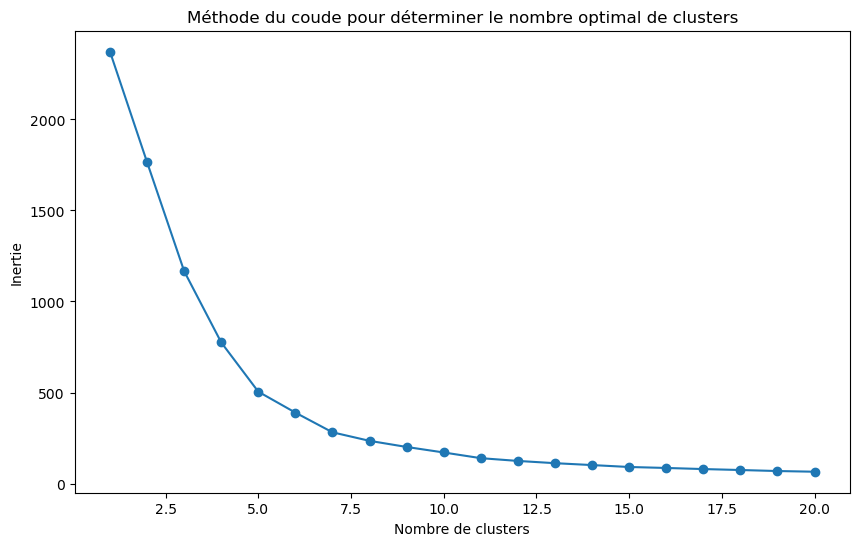

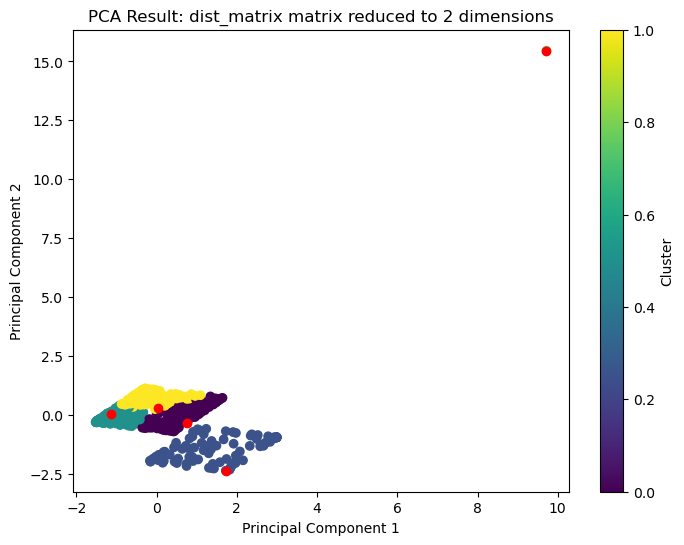

In [20]:
Time_Clust_parameters=Mcfconf.set_Time_clust_parameters(Ac_config)
Aggreg_Time_clust=McfC.cluster(Aggreg_Patients,Time_Clust,False,mlflow,Time_Clust_parameters )

In [21]:
#SAVE CLUSTERING TO BDD
Mydf=Aggreg_Time_clust['df_dist'][['NIP',Time_Clust_parameters['clust_name']]]
Mcfcp.Save_only_Cluster_to_Database(Mydf,Time_Clust_parameters, myouputpath, 'Tmp_' + Time_Clust_parameters['clust_name'] )
print('Save First clustering to BDD (Principal clust) OK')

2023-12-20 09:47:47,987 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-20 09:47:47,988 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Cl_T1
2023-12-20 09:47:47,989 INFO sqlalchemy.engine.Engine [generated in 0.00087s] ()
2023-12-20 09:47:47,996 INFO sqlalchemy.engine.Engine COMMIT
2023-12-20 09:47:48,003 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2023-12-20 09:47:48,004 INFO sqlalchemy.engine.Engine [generated in 0.00094s] ('Tmp_Cl_T1', 'dbo')
2023-12-20 09:47:48,008 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-20 09:47:48,010 INFO sqlalchemy.engine.Engine 
CREATE TABLE [Tmp_Cl_T1] (
	[index] BIGINT NULL, 
	[NIP] VARCHAR(max) NULL, 
	[Cl_T1] INTEGER NULL
)


2023-12-20 09:47:48,010

#### PREPARATION CLUSTERING DE PARCOURS - CREATION DE COURBES CARACTERISTIQUES DE PARCOURS

In [25]:
dtw_param=Mcfconf.get_dtw_param(Ac_config)
dist_matrix=Mcftsc.GetDistanceMatrix(Aggreg_Patients, Aggreg_parameters,Aggprefix,dtw_param)

#EXPORT DE LA MATRICE DE DISTANCE
#dist_matrix.tofile(myouputpath + "Matrice_distance.dat")
np.savetxt(myouputpath + "distance_matrix.csv",dist_matrix,delimiter=",")
mlflow.log_artifact(myouputpath + "distance_matrix.csv", "Matrice de distance inter-Parcours")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Iteration 0/592 - Temps restant estimé: 0.89 minutes
Iteration 100/592 - Temps restant estimé: 0.84 minutes
Iteration 200/592 - Temps restant estimé: 0.66 minutes
Iteration 300/592 - Temps restant estimé: 0.44 minutes
Iteration 400/592 - Temps restant estimé: 0.26 minutes
Iteration 500/592 - Temps restant estimé: 0.11 minutes
Durée totale de traitement: 36.82 secondes


#### CLUSTERING DES FONCTIONS DE PARCOURS


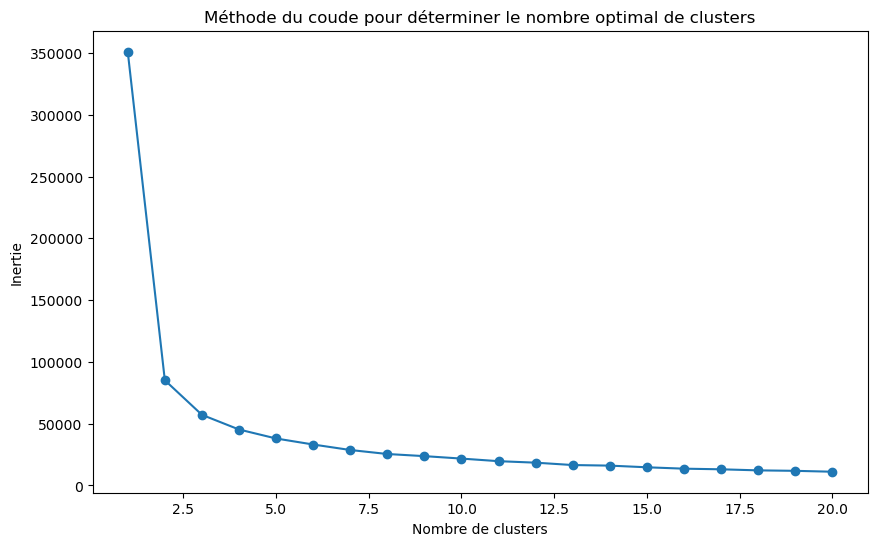

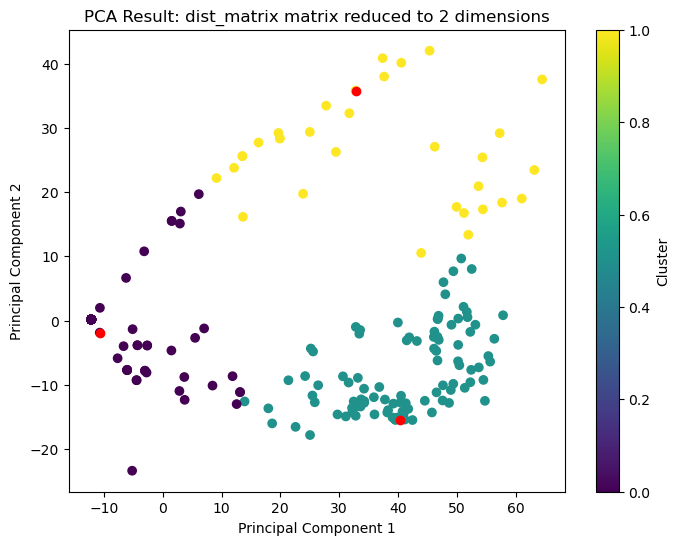

In [ ]:
Parcours_Clust_parameters=Mcfconf.set_parcours_clust_parameters(Ac_config)
Aggreg_Parcours_clust=McfC.cluster(Aggreg_Patients,dist_matrix,False,mlflow,Parcours_Clust_parameters )

In [ ]:
#SAVE CLUSTERING TO BDD
Mydf=Aggreg_Parcours_clust['df_dist'][['NIP',Parcours_Clust_parameters['clust_name']]]
Mcfcp.Save_only_Cluster_to_Database(Mydf,Parcours_Clust_parameters, myouputpath, 'Tmp_' + Parcours_Clust_parameters['clust_name'] )
print('Save Second clustering to BDD (Principal clust) OK')

2023-12-19 16:29:59,572 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-19 16:29:59,573 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_Cl_P1
2023-12-19 16:29:59,574 INFO sqlalchemy.engine.Engine [generated in 0.00045s] ()
2023-12-19 16:29:59,578 INFO sqlalchemy.engine.Engine COMMIT
2023-12-19 16:29:59,582 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2023-12-19 16:29:59,582 INFO sqlalchemy.engine.Engine [cached since 39.18s ago] ('Tmp_Cl_P1', 'dbo')
2023-12-19 16:29:59,585 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-19 16:29:59,585 INFO sqlalchemy.engine.Engine 
CREATE TABLE [Tmp_Cl_P1] (
	[index] BIGINT NULL, 
	[NIP] VARCHAR(max) NULL, 
	[Cl_P1] INTEGER NULL
)


2023-12-19 16:29:59,5

#### PLOT CLUSTERS PARCOURS CURVE

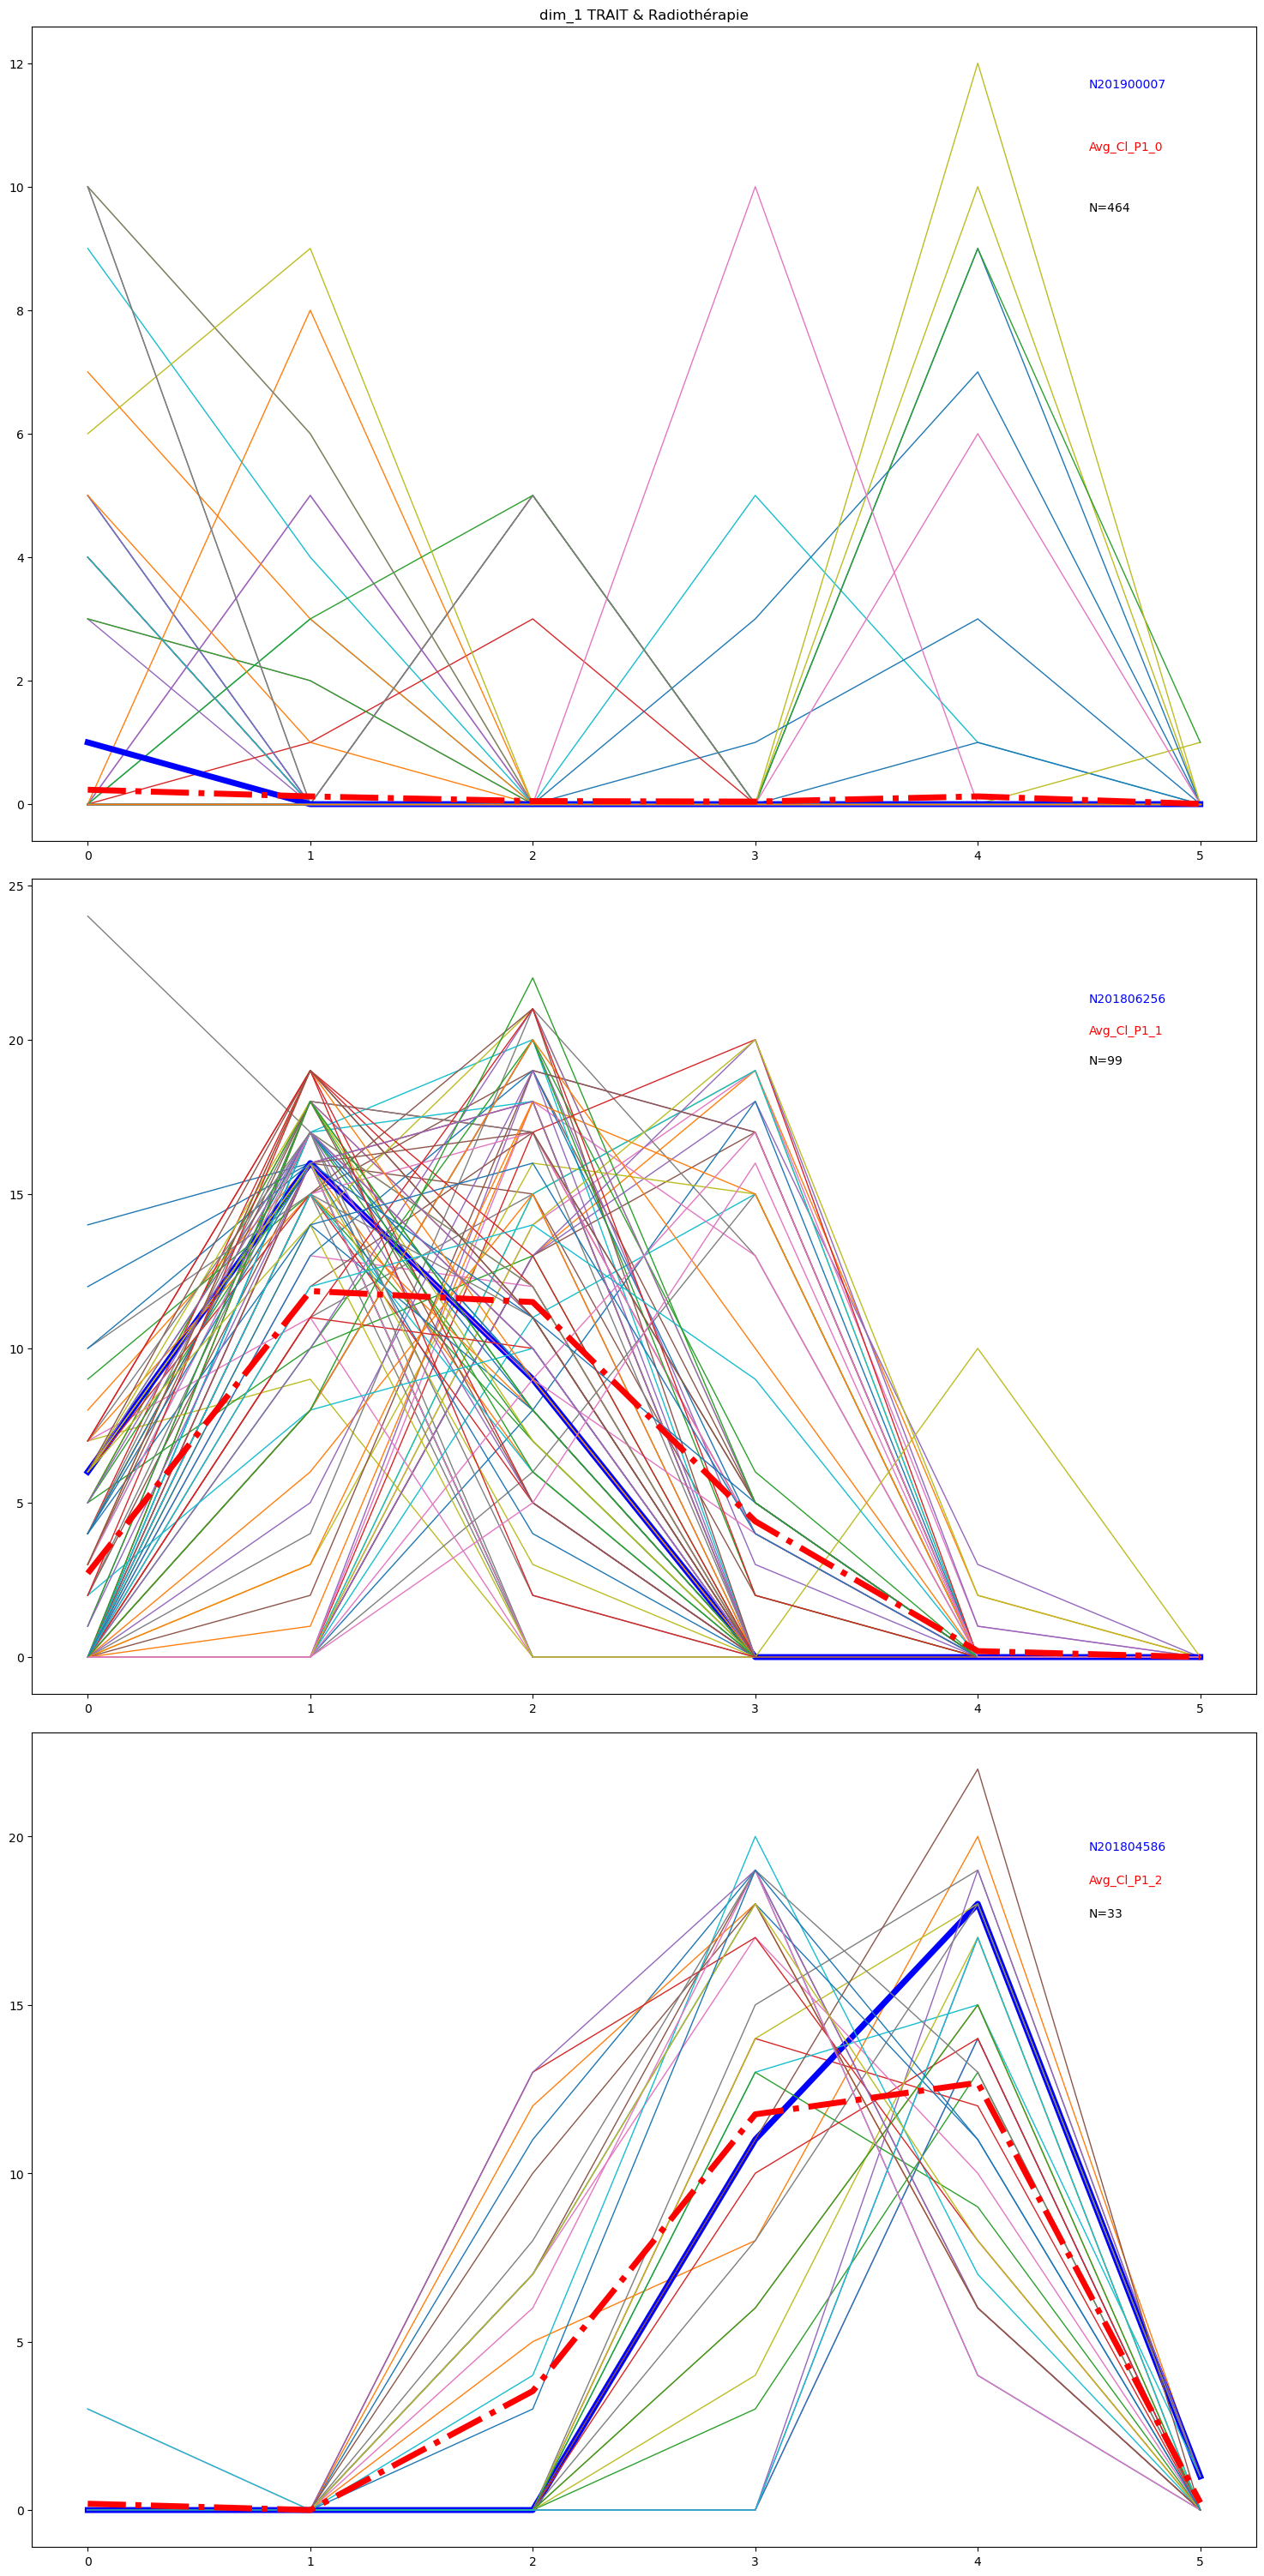

In [ ]:
import importlib
importlib.reload(Mcftsc)

Timesteps=int(Aggreg_parameters[Aggprefix + 'Stop_at_item'])-int(Aggreg_parameters[Aggprefix + 'Start_at_item'])
clust_name=Parcours_Clust_parameters['clust_name']

Parcours_nb_clusters={
    'nb_cluster' : Aggreg_Parcours_clust['Nb_clusters'],
    'Column_name' : Parcours_Clust_parameters['clust_name'],
}

Mcftsc.plot_TS_clusters(Aggreg_Parcours_clust,Timesteps,myouputpath+ 'TS_curves.png',Parcours_nb_clusters)
mlflow.log_artifact(myouputpath+ 'TS_curves.png', "TS_Curves_Clustering")

#### PLOT LE CLUSTERING DE PARCOURS

ORDER THE CAREPATHES BY TIME
UNE ALTERNATIVE SERAIT DE PRENDRE LE PARCOURS MOYEN DU CLUSTER ET DE CLASSER PAR DISTANCE D'ECART AU PARCOURS MOYEN.

In [ ]:
#Get the plot parameters
My_order=Ac_config['CPP_Order']
Table_name=Ac_config['CPP_Save_Tble_Name']
Requete=Ac_config['CPP_Requete']
Filter_df_col=Ac_config['CPP_Filter_df_col']
Filter_df_value=Ac_config['CPP_Filter_df_value']

In [ ]:

#PREPARE THE DATASET TO BE PLOTED
Parcours_DF=Mcfcp.Prepare_Plot_carepath_clustered_2levels(df_Actes_graph,Aggreg_Parcours_clust,Parcours_Clust_parameters,Aggreg_Time_clust,Time_Clust_parameters, My_order)
Abcisses_DF, Plot_dict =Mcfcp.Compute_abcisses(Parcours_DF,Parcours_Clust_parameters,Time_Clust_parameters)

#SAVE THE CLUSTERING + PLOTTING VALUES TO THE DATABASE
Mcfcp.Save_Cluster_and_Carepath_to_Database(Abcisses_DF,Parcours_Clust_parameters,Time_Clust_parameters,myouputpath,Table_name)

2023-12-19 16:32:08,830 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-19 16:32:08,831 INFO sqlalchemy.engine.Engine EXECUTE dbo.Delete_Table_if_exists Tmp_NIP_Cluster
2023-12-19 16:32:08,831 INFO sqlalchemy.engine.Engine [generated in 0.00048s] ()
2023-12-19 16:32:08,834 INFO sqlalchemy.engine.Engine COMMIT
2023-12-19 16:32:08,838 INFO sqlalchemy.engine.Engine SELECT [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME], [INFORMATION_SCHEMA].[TABLES].[TABLE_TYPE] 
FROM [INFORMATION_SCHEMA].[TABLES] 
WHERE [INFORMATION_SCHEMA].[TABLES].[TABLE_NAME] = CAST(? AS NVARCHAR(max)) AND [INFORMATION_SCHEMA].[TABLES].[TABLE_SCHEMA] = CAST(? AS NVARCHAR(max))
2023-12-19 16:32:08,839 INFO sqlalchemy.engine.Engine [cached since 168.4s ago] ('Tmp_NIP_Cluster', 'dbo')
2023-12-19 16:32:08,841 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-12-19 16:32:08,842 INFO sqlalchemy.engine.Engine 
CREATE TABLE [Tmp_NIP_Cluster] (
	[index] BIGINT NULL, 
	[NIP] VARCHAR(max) NULL, 
	[Cl_P1] FLOAT(53) NULL, 
	[C

In [ ]:
#Recuperer une table acte avec les clusters
#Requete="""SELECT Table_Acte.[NIP]
#	  ,Table_Cluster.CL_T1 as Clust
#	  ,Table_Cluster.X_abscisse
#      ,Table_Acte.[J_Parcours_V1]
#      ,Table_Acte.[J_Parcours_V3]
#      ,Table_Acte.[Service]
#      ,Table_Acte.[Activite]
#      ,Table_Acte.[Phase]
#      ,Table_Acte.[Dimension]
#      ,Table_Acte.[Type_seq]
#  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
#	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
#  WHERE Table_Cluster.NIP = Table_Acte.NIP
#  ORDER BY Clust asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
#"""



df_Actes_graph2=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

filtered_df = df_Actes_graph2[df_Actes_graph2[Filter_df_col] == Filter_df_value]
nip_no_treatment_info = df_Actes_graph2[~df_Actes_graph2['NIP'].isin(filtered_df['NIP'])]
nip_no_treatment_info = nip_no_treatment_info[['NIP', 'Clust', 'X_abscisse']].drop_duplicates()
final_df = pd.concat([filtered_df, nip_no_treatment_info], ignore_index=True)
final_df_sorted = final_df.sort_values(by='X_abscisse')

2023-12-19 16:32:09,029 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  ,Table_Cluster.CL_T1 as Clust
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
  ORDER BY Clust asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
2023-12-19 16:32:09,029 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


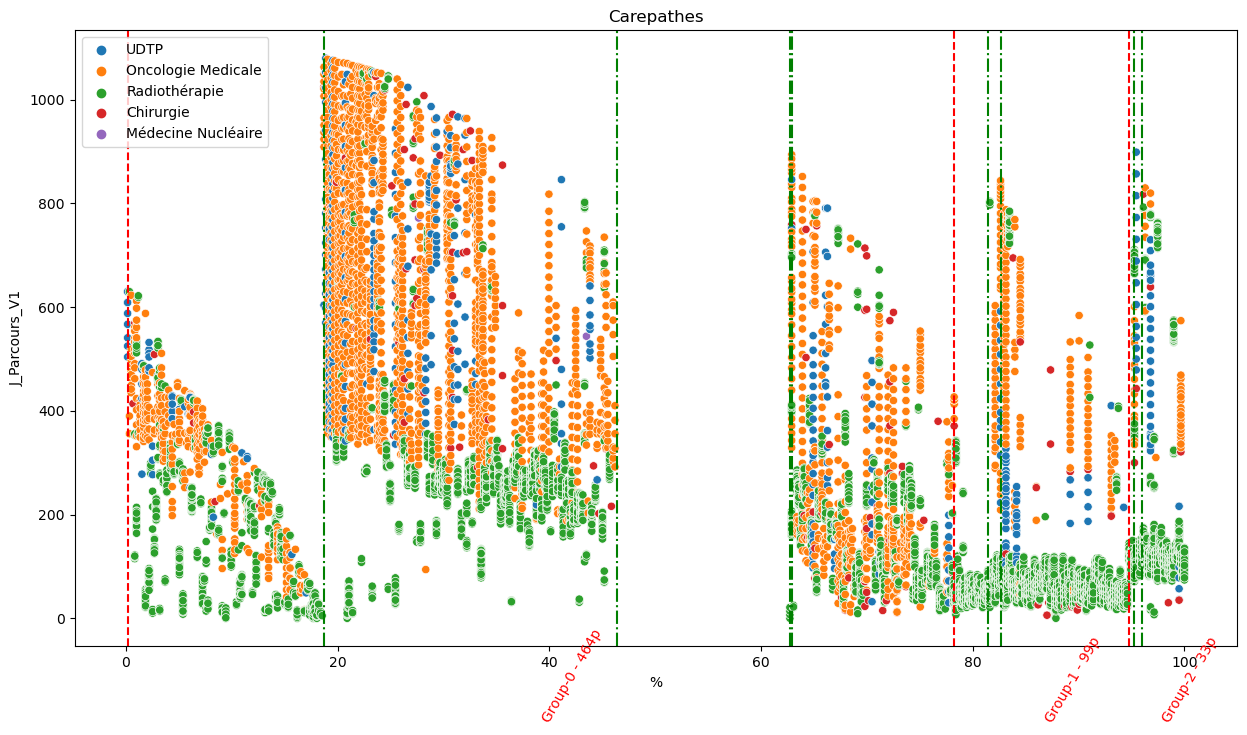

<module 'matplotlib.pyplot' from 'c:\\Anaconda\\envs\\Parcours\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
import importlib
importlib.reload(Mcfcp)
Mcfcp.plot_df_actes(final_df_sorted,Aggreg_Parcours_clust,Parcours_Clust_parameters,Aggreg_Time_clust,Time_Clust_parameters, Plot_dict, mlflow, myouputpath)

In [ ]:
# CLOSE THE MLFLOW
mlflow.end_run()

In [ ]:
#Recuperer une table acte avec les clusters
#Requete="""SELECT Table_Acte.[NIP]
#	  ,Table_Cluster.CL_T1 as Clust
#	  ,Table_Cluster.X_abscisse
#      ,Table_Acte.[J_Parcours_V1]
#      ,Table_Acte.[J_Parcours_V3]
#      ,Table_Acte.[Service]
#      ,Table_Acte.[Activite]
#      ,Table_Acte.[Phase]
#      ,Table_Acte.[Dimension]
#      ,Table_Acte.[Type_seq]
#  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
#	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
#  WHERE Table_Cluster.NIP = Table_Acte.NIP
#  ORDER BY Clust asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
#"""



df_Actes_graph2=AlSQL.AlSQL_Requete(AlSQL.engine,Requete,'No')

filtered_df = df_Actes_graph2[df_Actes_graph2['Phase'] == 'Traitement']
nip_no_treatment_info = df_Actes_graph2[~df_Actes_graph2['NIP'].isin(filtered_df['NIP'])]
nip_no_treatment_info = nip_no_treatment_info[['NIP', 'Clust', 'X_abscisse']].drop_duplicates()
final_df = pd.concat([filtered_df, nip_no_treatment_info], ignore_index=True)
final_df_sorted = final_df.sort_values(by='X_abscisse')

2023-12-19 16:32:10,888 INFO sqlalchemy.engine.Engine SELECT Table_Acte.[NIP]
	  ,Table_Cluster.CL_T1 as Clust
	  ,Table_Cluster.X_abscisse
      ,Table_Acte.[J_Parcours_V1]
      ,Table_Acte.[J_Parcours_V3]
      ,Table_Acte.[Service]
      ,Table_Acte.[Activite]
      ,Table_Acte.[Phase]
      ,Table_Acte.[Dimension]
      ,Table_Acte.[Type_seq]
  FROM [ICO_Activite].[dbo].[Tmp_Carac_Actes] as Table_Acte
	 , [ICO_Activite].[dbo].[Tmp_NIP_Cluster] as Table_Cluster
  
  WHERE Table_Cluster.NIP = Table_Acte.NIP
  ORDER BY Clust asc ,Table_Acte.[J_Parcours_V1] desc, Table_Acte.[NIP]
2023-12-19 16:32:10,889 INFO sqlalchemy.engine.Engine [raw sql] ()
AlSQL_Requete - OK


## INTERSECTION DE TOUTES LES AGGREGATIONS ET CLUSTERING

In [ ]:
# ADD HERE THE RESULT PLOT OF THE INTERSECTION OF ALL CLUSTERING DIMENSIONS.

## FIN DU PROGRAMME